In [1]:
# Basic
import pandas as pd
import numpy as np
import random

# UMAP
import umap
import umap.plot

import hdbscan

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import seaborn as sns

# Stats
import sklearn

from scipy.stats import kruskal
from scipy.stats import wilcoxon
from scipy.stats import f_oneway
from scikit_posthocs import posthoc_dunn

import skbio
from skbio import DistanceMatrix
from skbio.stats.distance import permanova

from skbio.diversity import beta_diversity

/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a 

In [2]:
np.random.seed(410)
reducer = umap.UMAP(random_state=42)
reducer_clustering = umap.UMAP(    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,)
hdbscan_alg = hdbscan.HDBSCAN(
        min_samples=10,
        min_cluster_size=500,
        gen_min_span_tree=False,
        approx_min_span_tree=False
    )

# If HDBSCAN use desired
def embed_umap(data):

    embedding = reducer.fit_transform(data)
    clusterable_embedding = reducer_clustering.fit_transform(data)
    cluster_labels = hdbscan_alg.fit_predict(clusterable_embedding)

    return embedding, cluster_labels, clusterable_embedding

def create_cancer_umap(embedding, labels, title, cancer_list):
    
    # Filter cancer patients
    cancer_patients = (labels > 0)
    
    # Plot non-cancer patients

    if len(embedding[~cancer_patients]) != 0:
        plt.scatter(embedding[~cancer_patients, 0],
                    embedding[~cancer_patients, 1],
                    color=(0.5, 0.5, 0.5),
                    s=8,
                    alpha=1,
                    label="No Cancer")
    
    # Get unique cancer labels
    unique_labels = np.unique(labels[cancer_patients])
    
    # Create color map
    cmap = plt.get_cmap('Spectral', len(unique_labels))
    
    # Plot cancer patients with correct color mapping
    for i, cancer_type in enumerate(unique_labels):
        mask = labels == cancer_type
        plt.scatter(embedding[mask, 0],
                    embedding[mask, 1],
                    color=cmap(i / (len(unique_labels) - 1)) if len(unique_labels) > 1 else cmap(0),
                    s=8,
                    label=cancer_list[int(cancer_type) - 1] if int(cancer_type) > 0 else "Unknown")
    
    # Create legend handles that match the scatter plot colors
    handles = [mpatches.Patch(color=cmap(i / (len(unique_labels) - 1)) if len(unique_labels) > 1 else cmap(0), 
                             label=cancer_list[int(label) - 1] if int(label) > 0 else "Unknown")
               for i, label in enumerate(unique_labels)]
    
    # Add non-cancer handle
    if len(embedding[~cancer_patients]) != 0:
        handles.append(mpatches.Patch(color=(0.5, 0.5, 0.5), label="No Cancer"))
    
    plt.title(title)
    plt.legend(handles=handles, title="Patient Labels", fontsize=5)
    

def alternate_columns(df1, df2, suffix1="_cancer", suffix2="_control"):
    """
    Combines two DataFrames by alternating their columns and appends suffixes to column names.
    
    Parameters:
    df1 (pandas.DataFrame): First DataFrame
    df2 (pandas.DataFrame): Second DataFrame
    suffix1 (str): Suffix to append to column names from df1
    suffix2 (str): Suffix to append to column names from df2
    
    Returns:
    pandas.DataFrame: A new DataFrame with alternating columns from df1 and df2
    
    Note: If one DataFrame has more columns than the other, the remaining columns 
    will be appended at the end.
    """
    result = pd.DataFrame()
    
    # Get column names from both dataframes
    cols1 = df1.columns.tolist()
    cols2 = df2.columns.tolist()
    
    # Find the maximum length to iterate through
    max_cols = max(len(cols1), len(cols2))
    
    # Alternate columns from each dataframe
    for i in range(max_cols):
        # Add column from df1 if available with renamed column
        if i < len(cols1):
            new_col_name = cols1[i] + suffix1
            result[new_col_name] = df1[cols1[i]]
        
        # Add column from df2 if available with renamed column
        if i < len(cols2):
            new_col_name = cols2[i] + suffix2
            result[new_col_name] = df2[cols2[i]]
    
    return result





In [3]:
cancer_patients = pd.read_excel("../data/rise_cancer_data.xlsx")
all_patients = pd.read_csv("../data/rise_all_data.csv")

all_patients["cancer"] = all_patients["participantid"].isin(cancer_patients["participantid"])


In [22]:
all_patients

,participantid,b1_age,b1_e1,b1_e2,b1_e3,b1_e4_ft,b1_e4_in,b1_e4_cm,b1_e5_lbs,b1_e5_kg,...,bhs_6_adj,bhs_7_adj,bhs_8_adj,bhs_9_adj,bhs_10_adj,bfi_overall,bh_urobiome_barcode,pass_kseq_threshold,sample_type,cancer
0,EM003,55.0,1.0,2.0,5,5,5,NaN,263,NaN,...,NaN,38.364780,36.842105,28.638498,26.829268,63.596491,X00233456,y,research,False
1,EM008,30.0,1.0,2.0,3,5,7,NaN,190,NaN,...,60.000000,50.943396,58.704453,49.295775,56.097561,71.929825,X00233243,y,research,False
2,EM015,28.0,2.0,2.0,1,5,2,NaN,205,NaN,...,60.000000,32.704403,49.190283,34.741784,37.804878,47.368421,X00233822,y,research,False
3,EM023,23.0,1.0,1.0,5,5,4,NaN,205,NaN,...,54.761905,36.163522,53.643725,52.816901,51.219512,64.912281,X00232827,y,pilot2,False
4,EM032,51.0,2.0,2.0,5,5,5,NaN,214,NaN,...,65.714286,66.037736,63.562753,66.197183,60.975610,61.278195,X00233374,y,research,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,YU238,NaN,2.0,2.0,5,5,5,NaN,142,NaN,...,82.857143,73.584906,70.850202,76.056338,76.829268,94.736842,X00233109,y,research,True
509,YU242,68.0,1.0,1.0,5,5,4,NaN,137,NaN,...,18.095238,11.949686,14.170040,17.370892,18.699187,80.701754,X00233144,y,research,False
510,YU249,23.0,1.0,1.0,3,5,9,NaN,140,NaN,...,100.000000,100.000000,96.356275,100.000000,100.000000,100.000000,X00233926,n,research,False
511,YU253,79.0,1.0,2.0,5,5,6,NaN,147,NaN,...,28.095238,22.641509,NaN,65.727700,60.975610,74.561404,X00233665,n,research,False


In [4]:
keep_cols_major_health = ["b1_e8a", "b1_e8b", "b1_e8c", "b1_e8d", "b1_e8e", "b1_e8f", "b1_e8g", "b1_e8h", "b1_e8i", "b1_e8j", "b1_e9a", "b1_e9c", "b1_e9d", "b1_e9e", "b1_e9f", "b1_e9g","b1_e11", "b1_e11a", "b1_e11a1", "b1_e11b", "b1_e11c", "b1_e11d", "b1_e11e", "b1_e11f", "b1_e11g", "b1_e12a", "b1_e12b", "b1_e12c", "b1_e12d", "b1_e12e", "b1_e12f", "b1_e12g", "b1_e12h", "b1_e12i", "b1_e19", "b1_e20"]
keep_cols_derived = ["menopause_impute"]
keep_cols_derived_necessary = ["age_impute", "height", "weight", "bmi"]
keep_cols_derived_imputable = ["pregnant"]
keep_cols_scales = [ "bhs_1_adj", "bhs_2_adj", "bhs_3_adj", "bhs_4_adj", "bhs_5_adj", "bhs_6_adj", "bhs_7_adj", "bhs_8_adj", "bhs_9_adj", "bhs_10_adj", "bfi_biosis", "bfi_freq", "bfi_sensation", "bfi_continence", "bfi_comfort", "bfi_emptying"]
keep_cols_basic = ["participantid", "cancer"]

keep_cols_all_imputable = keep_cols_derived_imputable + keep_cols_major_health
keep_cols_all_unimputable = keep_cols_basic + keep_cols_derived_necessary + keep_cols_scales + keep_cols_derived

all_patients_filtered = all_patients[ keep_cols_all_unimputable + keep_cols_all_imputable]
all_patients_filtered = all_patients_filtered.dropna(axis=0, subset=keep_cols_all_unimputable)
all_patients_filtered = all_patients_filtered.fillna(value=0)

all_patients_filtered_ohe = pd.get_dummies(all_patients_filtered, columns=keep_cols_derived)
all_patients_filtered_ohe[keep_cols_all_imputable] = all_patients_filtered_ohe[keep_cols_all_imputable].astype(bool)


cancer_column_labels = ["b1_e11", "b1_e11a", "b1_e11b","b1_e11c","b1_e11d","b1_e11e","b1_e11g"]
cancer_names = ["Unknown/Other Cancer", "Bladder", "Uterine", "Cervical", "Ovarian", "Colon", "Breast"]
cancer_column_label_dict = {col: i + 1 for i, col in enumerate(cancer_column_labels)}
cancer_column_label_dict["0"] = 0
cancer_column_dependents = ["b1_e11a1", "b1_e11f"]



# FOR VISUALIZATION ONLY, WE SET PATIENT UP137 (true for e11b, e11d, e11e (uterus, ovaries, and colon cancer) TO HAVE ONLY UTERINE CANCER ONLY (e11b)
all_patients_filtered_ohe.loc[all_patients_filtered_ohe["participantid"] == "UP137", "b1_e11d"] = False
all_patients_filtered_ohe.loc[all_patients_filtered_ohe["participantid"] == "UP137", "b1_e11e"] = False
# We also set "b1_e11" to  0 in rows where the patient has "b1_e11a", "b1_e11b","b1_e11c","b1_e11d","b1_e11e","b1_e11g" equal to 1
for row in all_patients_filtered_ohe.iterrows():
    if row[1]["b1_e11a"] or row[1]["b1_e11b"] or row[1]["b1_e11c"] or row[1]["b1_e11d"] or row[1]["b1_e11e"] or row[1]["b1_e11g"]:
        all_patients_filtered_ohe.loc[row[0], "b1_e11"] = False

specific_cancer_labels = pd.DataFrame(columns=["cancer"])
specific_cancer_labels["cancer"] = pd.from_dummies(all_patients_filtered_ohe[cancer_column_labels], default_category="0")
specific_cancer_labels = specific_cancer_labels["cancer"].apply((lambda x: cancer_column_label_dict[x])).values
all_patients_filtered_ohe = all_patients_filtered_ohe.drop(columns=cancer_column_labels)
all_patients_filtered_ohe = all_patients_filtered_ohe.drop(columns=cancer_column_dependents)


all_patients_filtered_categorical = all_patients_filtered_ohe.loc[:, all_patients_filtered_ohe.dtypes == bool]
all_patients_filtered_numerical = all_patients_filtered_ohe.loc[:, all_patients_filtered_ohe.dtypes != bool]
all_patients_filtered_numerical = all_patients_filtered_numerical.drop(columns="participantid")
all_patients_filtered_labels = all_patients_filtered_categorical["cancer"].values
all_patients_filtered_categorical = all_patients_filtered_categorical.drop(columns="cancer")


all_patients_labels_categorical = all_patients_filtered_ohe.loc[:, all_patients_filtered_ohe.dtypes == bool]

all_patients_filtered_ohe["cancer_labels"] = specific_cancer_labels



In [5]:
all_patients_filtered_age_bmi = all_patients_filtered_ohe[["age_impute", "bmi"]]
age_bmi_umap = umap.UMAP(random_state=42).fit(sklearn.preprocessing.StandardScaler().fit_transform(all_patients_filtered_age_bmi.values))

/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


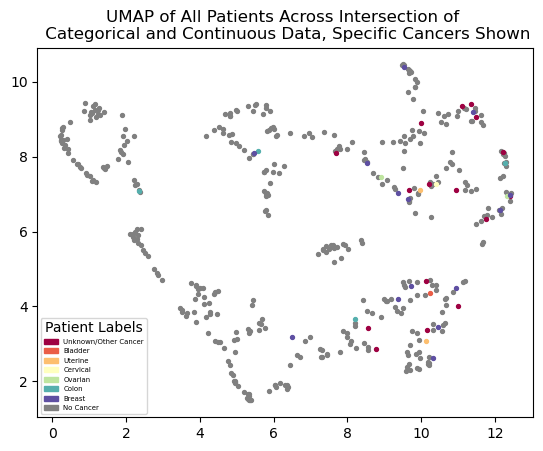

In [6]:
create_cancer_umap(age_bmi_umap.embedding_, specific_cancer_labels, "UMAP of All Patients Across Intersection of \n Categorical and Continuous Data, Specific Cancers Shown", cancer_names)

In [7]:
all_patients_distances = pd.DataFrame(columns=["participantid", "Cancer Type"])
all_patients_distances["participantid"] = all_patients_filtered_ohe["participantid"]
all_patients_distances["UMAP Coordinate"] = [row for row in age_bmi_umap.embedding_]
all_patients_distances["Cancer Type"] = specific_cancer_labels

non_cancer_distances = all_patients_distances[all_patients_distances["Cancer Type"] == 0]
cancer_distances = all_patients_distances[all_patients_distances["Cancer Type"] != 0]

# Get nearest non-cancer patient for each cancer patient
nearest_non_cancer = []
for cancer_patient in cancer_distances.iterrows():
    distances = np.linalg.norm(cancer_patient[1]["UMAP Coordinate"] - np.stack(non_cancer_distances["UMAP Coordinate"].values), axis=1)
    while True:
        if non_cancer_distances.iloc[np.argmin(distances)]["participantid"] not in nearest_non_cancer:
            nearest_non_cancer.append(non_cancer_distances.iloc[np.argmin(distances)]["participantid"])
            break
        else:
            distances[np.argmin(distances)] = np.inf    

cancer_distances["Nearest Non-Cancer Patient"] = nearest_non_cancer

/tmp/ipykernel_19928/3752454169.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_distances["Nearest Non-Cancer Patient"] = nearest_non_cancer


In [25]:
all_patients_distances

,participantid,Cancer Type,UMAP Coordinate
1,EM008,0,"[3.8867896, 4.572605]"
2,EM015,0,"[4.647166, 2.8924582]"
3,EM023,0,"[4.211573, 3.2924726]"
4,EM032,0,"[7.8795304, 3.3344564]"
5,EM043,0,"[7.893009, 5.6741133]"
...,...,...,...
507,YU232,0,"[0.8923527, 9.43111]"
508,YU238,1,"[10.0024185, 8.914362]"
509,YU242,0,"[11.035247, 7.6364217]"
510,YU249,0,"[0.23662351, 8.431041]"


In [26]:
all_patients_distances[all_patients_distances["participantid"]== "YU081"]

,participantid,Cancer Type,UMAP Coordinate
488,YU081,7,"[10.461014, 3.452742]"


Text(0.5, 1.0, 'Bladder Health Scales for Cancer Patients and Control Patients')

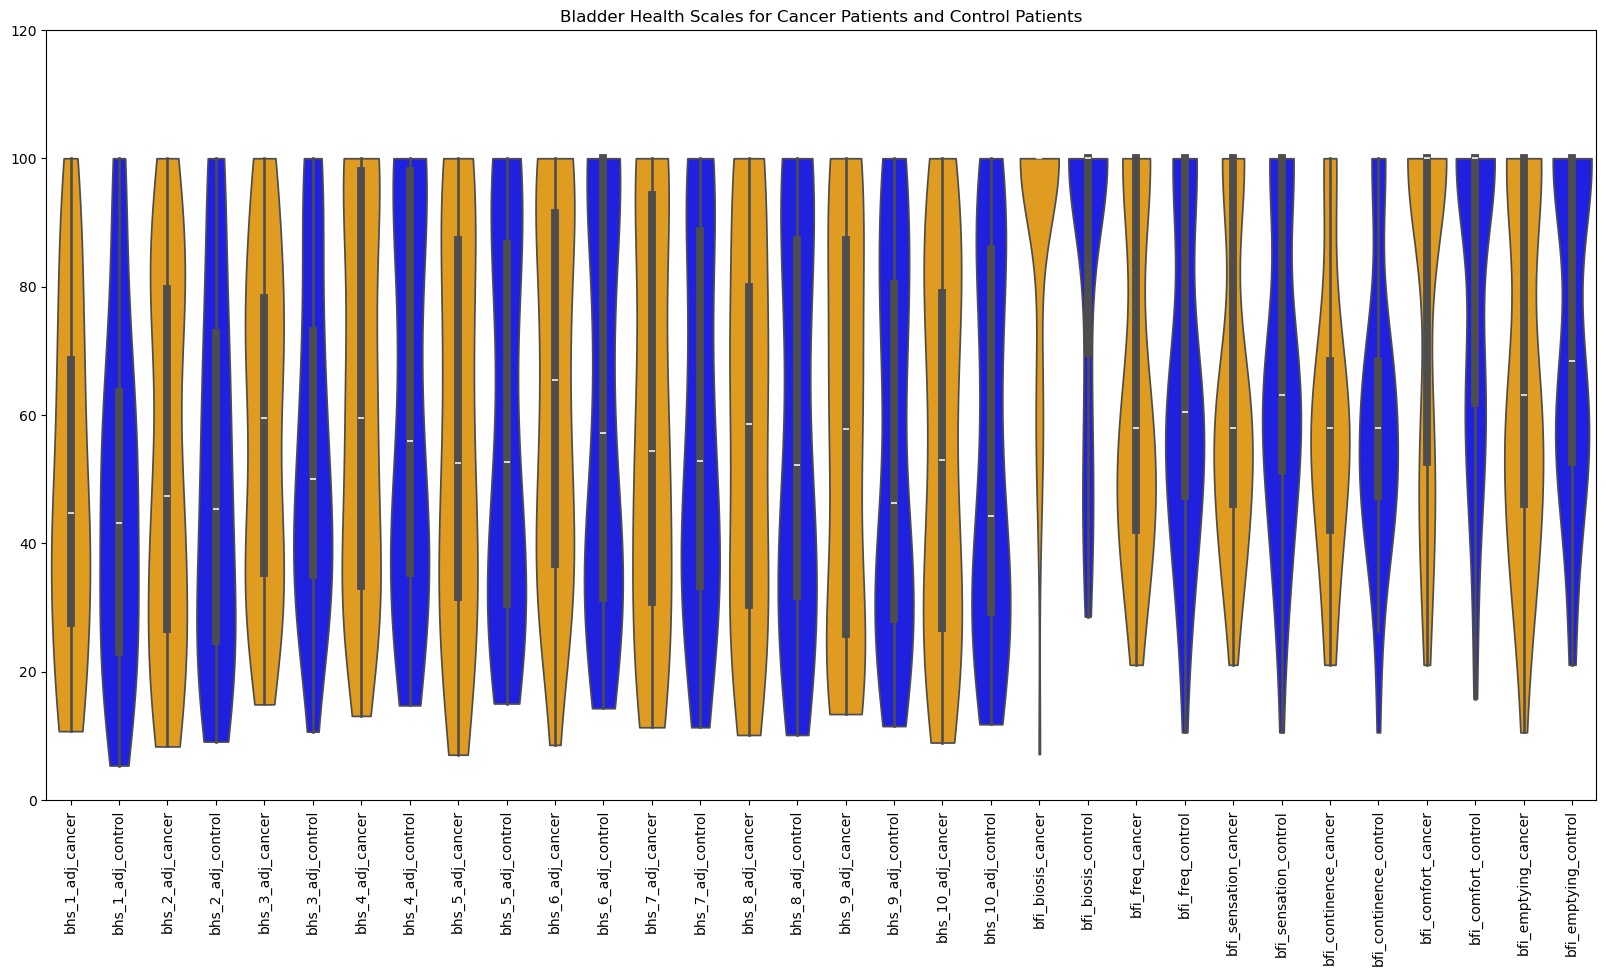

In [8]:
bladder_health_scales = all_patients_filtered_numerical.drop(columns=["age_impute", "height", "weight", "bmi"])
bladder_health_scales["participantid"] = all_patients_filtered_ohe["participantid"]

all_cancer_bladder_health_scales = bladder_health_scales[bladder_health_scales["participantid"].isin(cancer_distances["participantid"].values)]
all_non_cancer_bladder_health_scales = bladder_health_scales[bladder_health_scales["participantid"].isin(cancer_distances["Nearest Non-Cancer Patient"].values)]

all_cancer_bladder_health_scales = all_cancer_bladder_health_scales.drop(columns="participantid")
all_non_cancer_bladder_health_scales = all_non_cancer_bladder_health_scales.drop(columns="participantid")

violin_plot_df = alternate_columns(all_cancer_bladder_health_scales.reset_index().drop(columns="index"), all_non_cancer_bladder_health_scales.reset_index().drop(columns="index"))

custom_palette = ['orange', 'blue'] * 16

plt.figure(figsize=(20, 10))
plt.ylim(0, 120)

sns.violinplot(data=violin_plot_df, palette=custom_palette, cut=0)
plt.xticks(rotation=90)
plt.title("Bladder Health Scales for Cancer Patients and Control Patients")



In [9]:
# Iterate through each scale (i, i+2, i+4, ...) and perform Wilcoxon signed-rank test between i and i+1, i+2 and i+3, etc.


for i in range(0, len(violin_plot_df.columns), 2):
    print(wilcoxon(violin_plot_df.values.T[i], violin_plot_df.values.T[i+1]))



WilcoxonResult(statistic=np.float64(395.0), pvalue=np.float64(0.8471556244439853))
WilcoxonResult(statistic=np.float64(361.5), pvalue=np.float64(0.6908313423490776))
WilcoxonResult(statistic=np.float64(365.0), pvalue=np.float64(0.7271831935689568))
WilcoxonResult(statistic=np.float64(342.0), pvalue=np.float64(0.8860328563476569))
WilcoxonResult(statistic=np.float64(377.0), pvalue=np.float64(0.8560314678621759))
WilcoxonResult(statistic=np.float64(352.5), pvalue=np.float64(0.7940503336331588))
WilcoxonResult(statistic=np.float64(402.0), pvalue=np.float64(0.9143653367092703))
WilcoxonResult(statistic=np.float64(406.5), pvalue=np.float64(0.9624768817649366))
WilcoxonResult(statistic=np.float64(382.0), pvalue=np.float64(0.9111056355511453))
WilcoxonResult(statistic=np.float64(383.5), pvalue=np.float64(0.9277206350392628))
WilcoxonResult(statistic=np.float64(67.0), pvalue=np.float64(0.2589171342515342))
WilcoxonResult(statistic=np.float64(256.0), pvalue=np.float64(0.881027531900927))
Wilcox

In [10]:
cancer_names = ["Unknown/Other Cancer", "Bladder", "Uterine", "Cervical", "Ovarian", "Colon", "Breast"]
no_cancer = [0]
non_gyn_cancer = [1, 6]
gyn_breast_cancers = [3, 4, 5, 7]

bladder_health_scales["cancer_subtype"] = specific_cancer_labels
bladder_health_scales_filtered = bladder_health_scales[bladder_health_scales["cancer_subtype"] != 2]
bladder_health_scales_filtered["cancer_group"] = bladder_health_scales_filtered["cancer_subtype"].apply(lambda x: 0 if x in no_cancer else 1 if x in non_gyn_cancer else 2 if x in gyn_breast_cancers else 2193012309213120321321)

bhs_controls_filtered = bladder_health_scales_filtered[bladder_health_scales_filtered["participantid"].isin([item for item in cancer_distances["Nearest Non-Cancer Patient"].values.tolist() if item != "UC200"])]
bhs_cancer_filtered = bladder_health_scales_filtered[bladder_health_scales_filtered["cancer_group"] != 0]

bhs_cancer_controls = pd.concat([bhs_cancer_filtered, bhs_controls_filtered], axis=0)
bhs_cancer_controls.drop(columns=["participantid", "cancer_subtype"], inplace=True)

/tmp/ipykernel_19928/2413511615.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bladder_health_scales_filtered["cancer_group"] = bladder_health_scales_filtered["cancer_subtype"].apply(lambda x: 0 if x in no_cancer else 1 if x in non_gyn_cancer else 2 if x in gyn_breast_cancers else 2193012309213120321321)


In [11]:
for column in bhs_cancer_controls.columns:
    distance_matrix = beta_diversity("euclidean", bhs_cancer_controls[column].values.reshape(-1,1), ids=bhs_cancer_controls.index)

    # Convert to a DistanceMatrix object
    dm = DistanceMatrix(distance_matrix, ids=bhs_cancer_controls.index)

    # Grouping variable
    grouping = bhs_cancer_controls['cancer_group']

    # Perform PERMANOVA
    result = permanova(distance_matrix=dm, grouping=grouping, permutations=999)
    print(f"{column}: {result["p-value"]}")


bhs_1_adj: 0.443
bhs_2_adj: 0.31
bhs_3_adj: 0.457
bhs_4_adj: 0.618
bhs_5_adj: 0.749
bhs_6_adj: 0.55
bhs_7_adj: 0.711
bhs_8_adj: 0.716
bhs_9_adj: 0.647
bhs_10_adj: 0.664
bfi_biosis: 0.337
bfi_freq: 0.71
bfi_sensation: 0.664
bfi_continence: 0.614
bfi_comfort: 0.963
bfi_emptying: 0.45


/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/skbio/stats/distance/_permanova.py:136: RuntimeWarning: divide by zero encountered in scalar divide
  return (s_A / (num_groups - 1)) / (s_W / (sample_size - num_groups))


cancer_group: 0.001


In [12]:
# Iterate through each column, group by cancer group, and perform kruskal test
for i, column in enumerate(bhs_cancer_controls.columns):
    if column == "cancer_group":
        continue
    print(f"{column}: {kruskal(*[j[1].loc[:, j[1].columns[i]].values for j in bhs_cancer_controls.groupby("cancer_group")]).pvalue}")

    # Also get mean median and std for each group
    # print(f"Mean: {np.round(bhs_cancer_controls.groupby("cancer_group").mean().loc[:, column].values, 3).tolist()}")
    # print(f"Median: {np.round(bhs_cancer_controls.groupby("cancer_group").median().loc[:, column].values, 3).tolist()}")
    # print(f"STD: {np.round(bhs_cancer_controls.groupby("cancer_group").std().loc[:, column].values, 3).tolist()}")


bhs_1_adj: 0.3763927543022616
bhs_2_adj: 0.28584289665371293
bhs_3_adj: 0.40223107531836155
bhs_4_adj: 0.5889371896840838
bhs_5_adj: 0.5814754969091118
bhs_6_adj: 0.5198157910526899
bhs_7_adj: 0.7580590248726581
bhs_8_adj: 0.6646718740129873
bhs_9_adj: 0.708728823994849
bhs_10_adj: 0.6496630619224567
bfi_biosis: 0.16619661502447647
bfi_freq: 0.7985194911481323
bfi_sensation: 0.5190136253580844
bfi_continence: 0.47225912998855335
bfi_comfort: 0.9523460272974508
bfi_emptying: 0.4518019071378412


In [13]:
bladder_health_scale_labels = bladder_health_scales["cancer_subtype"]
bladder_health_scales_only = bladder_health_scales.drop(columns=["participantid", "cancer_subtype"])
bhs_umap = umap.UMAP(random_state=42).fit(sklearn.preprocessing.StandardScaler().fit_transform(bladder_health_scales_only.values))

/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


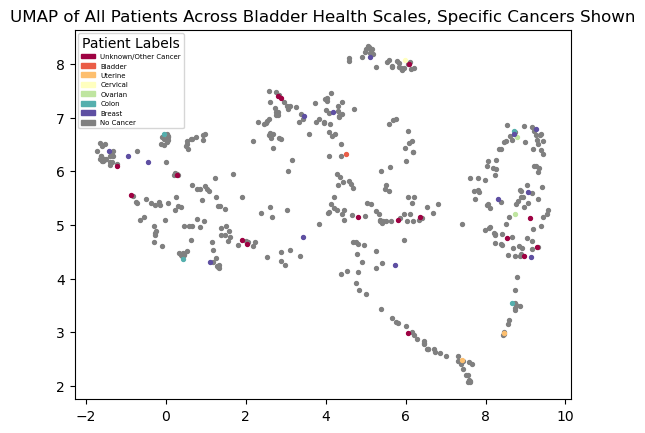

In [14]:
create_cancer_umap(bhs_umap.embedding_, bladder_health_scale_labels, "UMAP of All Patients Across Bladder Health Scales, Specific Cancers Shown", cancer_names)

In [15]:
keep_categorical_updated = ["b1_e8a", "b1_e8b", "b1_e8c", "b1_e8d", "b1_e8e", "b1_e8f", "b1_e8g", "b1_e8h", "b1_e8i", "b1_e8j", "b1_e9a", "b1_e9c", "b1_e9d", "b1_e9e", "b1_e9f", "b1_e9g","b1_e19", "b1_e20", "pregnant","menopause_impute_1", "menopause_impute_2", "menopause_impute_3", "menopause_impute_88"]
keep_numerical_updated =["age_impute","bmi"]
all_patients_filtered_updated = all_patients_filtered_ohe[keep_numerical_updated + keep_categorical_updated + bladder_health_scales_only.columns.tolist()]
all_patients_filtered_updated["cancer_labels"] = specific_cancer_labels

/tmp/ipykernel_19928/1288118360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_patients_filtered_updated["cancer_labels"] = specific_cancer_labels


In [16]:
# sns.pairplot(all_patients_filtered_updated, 
#              hue="cancer_labels", 
#              diag_kind="kde", 
#              palette="Spectral", 
#              plot_kws={"alpha": 0.5},
#              vars = keep_numerical_updated + bladder_health_scales_only.columns.tolist()
#              )


In [17]:
# pair_plot = sns.pairplot(all_patients_filtered_updated, hue="cancer_labels", diag_kind="kde", palette="Spectral", plot_kws={"alpha": 0.5})
# pair_plot.savefig("../output_data/pairplot_subset.png")

Finished 0 rows
Finished 10 rows
Finished 20 rows


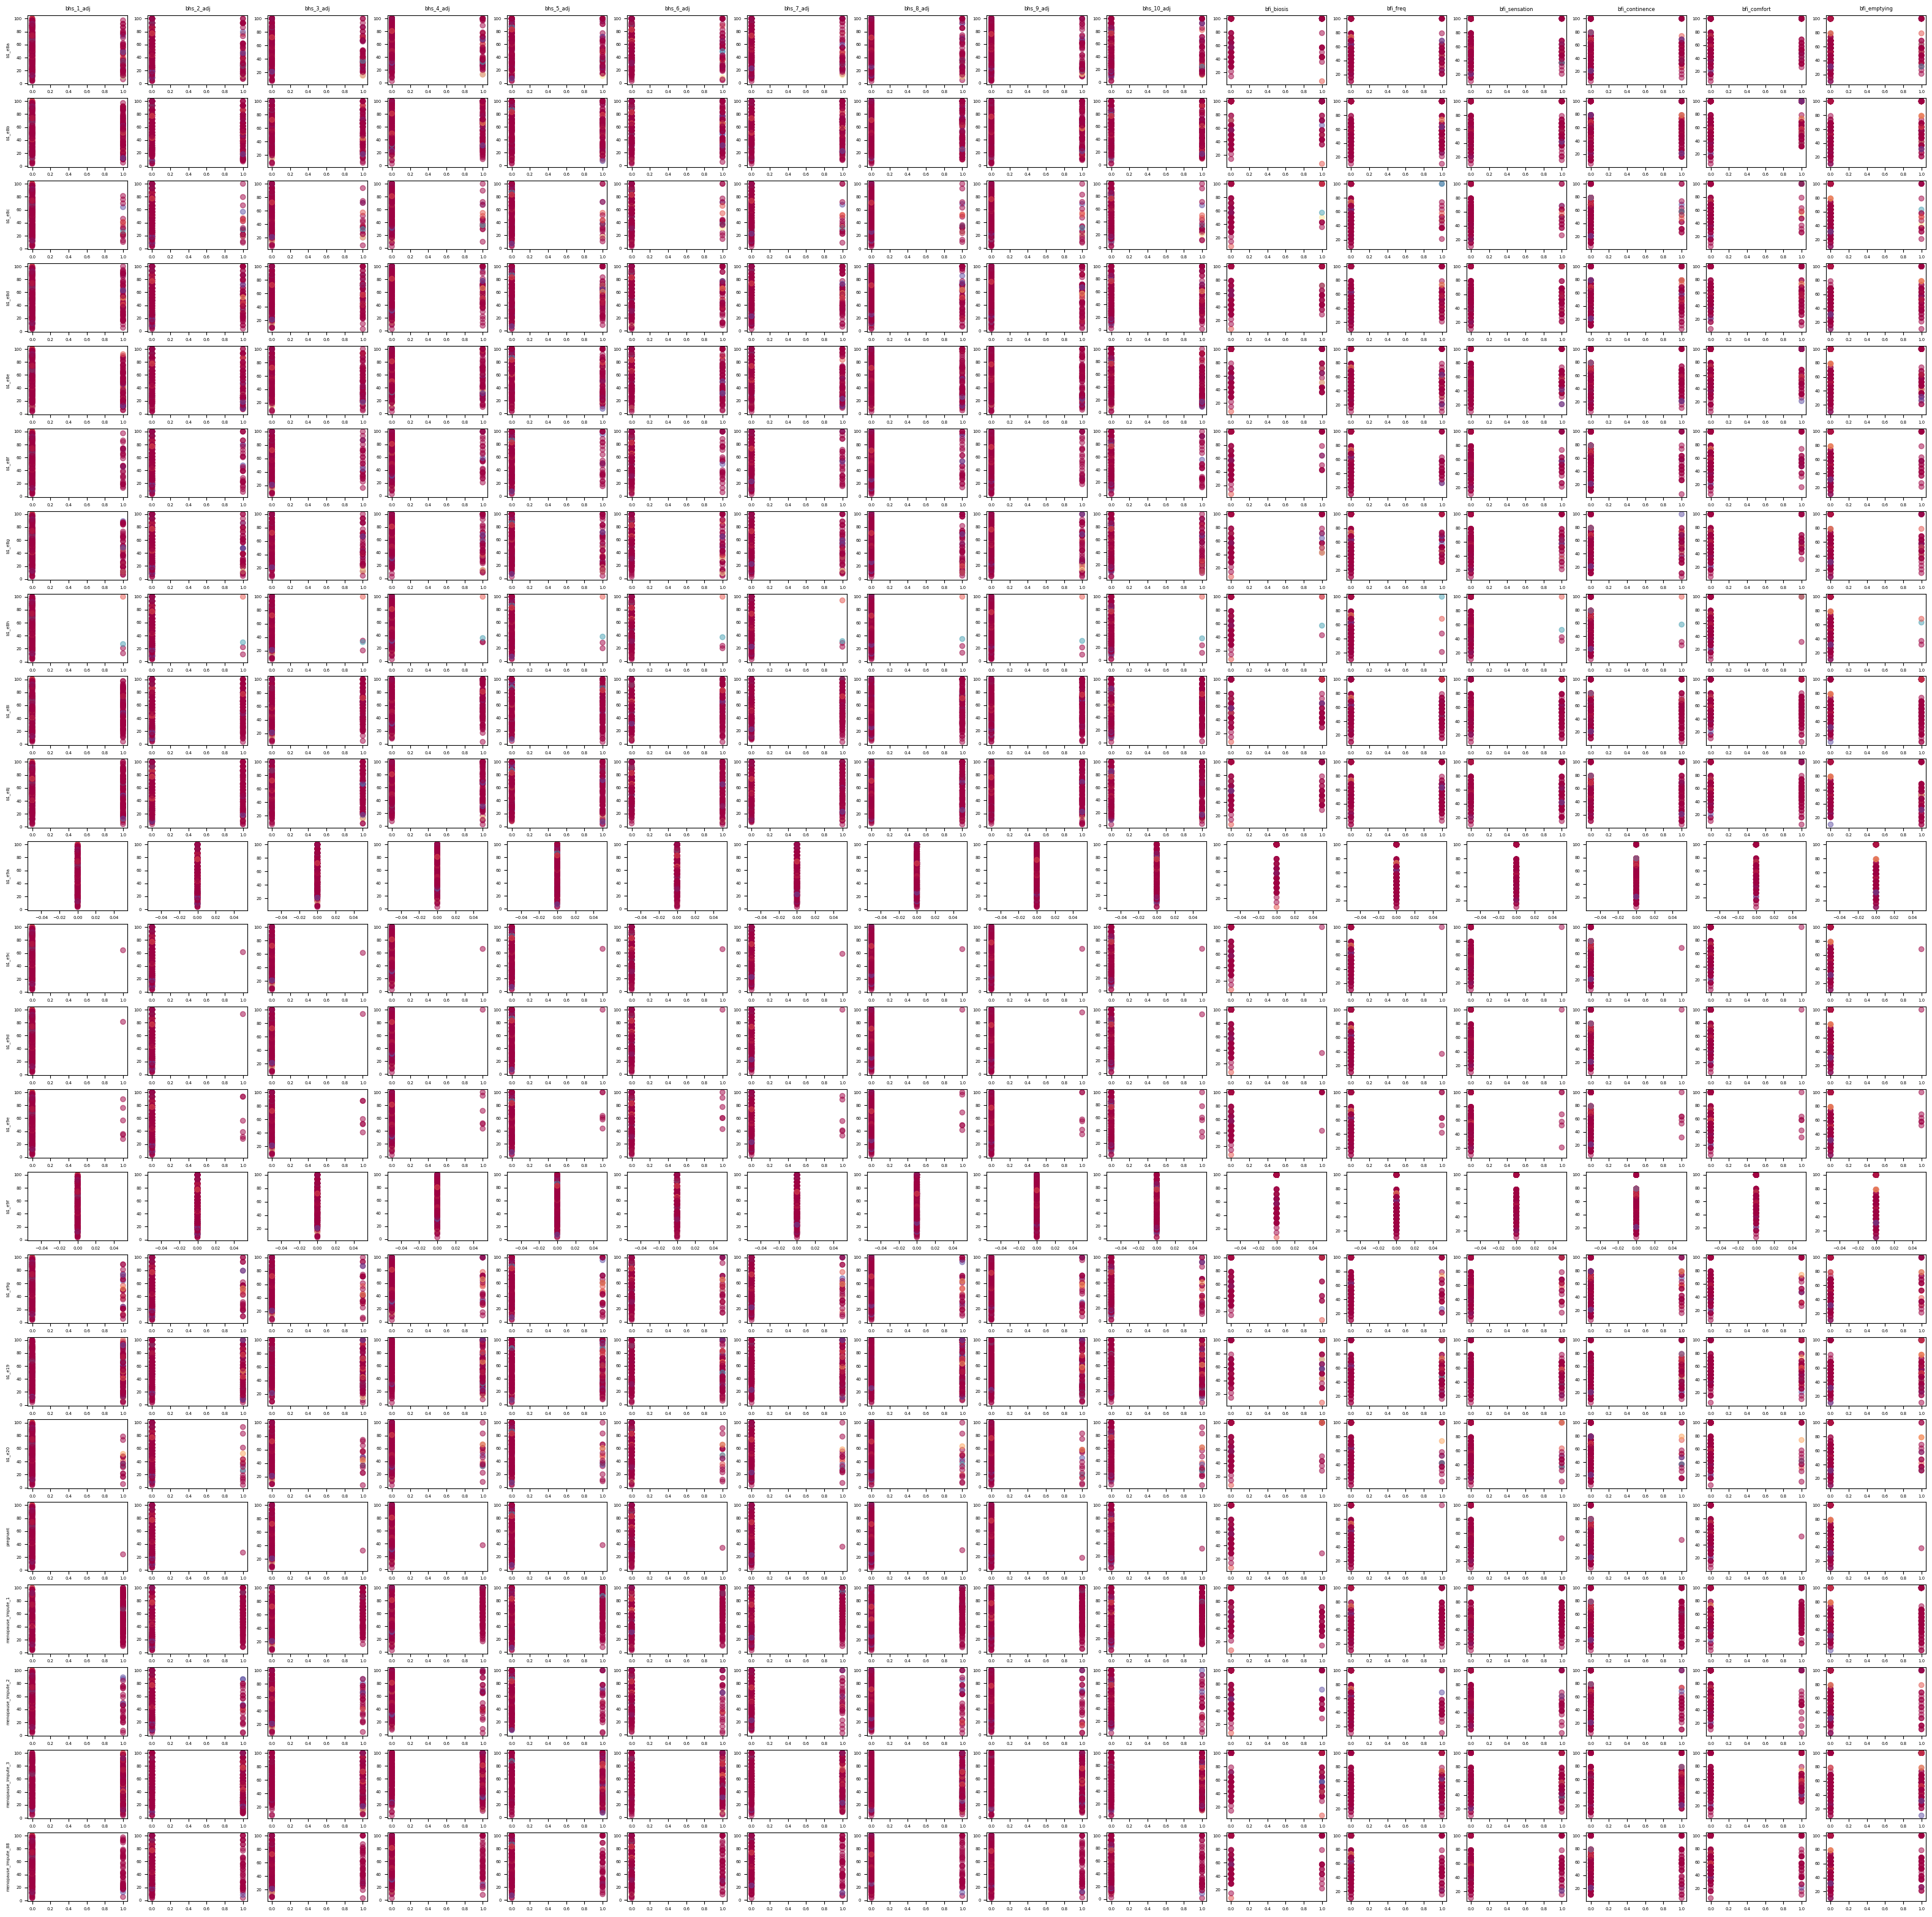

In [21]:
# Scatter bladder scales against categorical data

subplot_fig, subplot_axes = plt.subplots(len(keep_categorical_updated), len(bladder_health_scales_only.columns.tolist()), figsize=(40, 40))

# Make text miniscule only label for plots on the edges
plt.rc('font', size=5)
for i, categorical_col in enumerate(keep_categorical_updated):
    for j, scale_col in enumerate(bladder_health_scales_only.columns.tolist()):
        subplot_axes[i, j].scatter(all_patients_filtered_updated[categorical_col], all_patients_filtered_updated[scale_col], c=all_patients_filtered_updated["cancer_labels"], cmap="Spectral", alpha=0.5)
        if i == 0:
            subplot_axes[i, j].set_title(scale_col)
        if j == 0:
            subplot_axes[i, j].set_ylabel(categorical_col)   

    if i % 10 == 0:
        print(f"Finished {i} rows")    
